## Attention scores

What relationships exists between pairwise attention scores and pairwise distances?

In [1]:
import sys
sys.path.append('..')

import os
import random

import numpy as np

import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from models.biased_attention_transformer import BiasedAttentionTransformer
from data import PointCloudDataset

%load_ext autoreload
%autoreload 2

In [2]:
radial_function_types = [
    ("GaussianKernel", {"n_kernels": 32}),
    ("ExpNegativePowerLaw", {}),
    ("Zeros", {}),
]

models = {}
for radial_function_type, kwargs in radial_function_types:
    model = BiasedAttentionTransformer(
        n_tokens=6, 
        out_features=3, 
        E=128, H=8, D=8, 
        dropout=0.1, 
        radial_function_type=radial_function_type, 
        **kwargs
    )

    kwargs = ''.join(str(v) for v in kwargs.values())
    model_dir = f"/scratch/midway3/jshe/molecular-attention-bias/homo_lumo_U/BiasedAttentionTransformer/{radial_function_type}{kwargs}/E128H8D8"
    run_id = os.listdir(model_dir)[0]
    model_file = os.path.join(model_dir, run_id, 'model.pt')
    state_dict = torch.load(model_file, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
    model.eval();

    models[radial_function_type] = model

In [3]:
dataset = PointCloudDataset(
    data_dir = "/scratch/midway3/jshe/data/qm9/scaffolded/validation/", 
    target_labels = ['U', 'G']
)
dataloader = DataLoader(
    dataset, batch_size=64, shuffle=True, 
    collate_fn=dataset.collate
)

# Get sample data

tokens, padding, r, y = next(iter(dataloader))
B, L, _ = r.shape

# Construct distance matrix

d = torch.norm(
    r.unsqueeze(1) - r.unsqueeze(2), 
    dim=-1
).unsqueeze(1).expand(B, 8, L, L)

d = d.nan_to_num(0, posinf=0, neginf=0)

# Construct mask to remove self and padding interactions

interaction_mask = (d != 0)
sample_mask = torch.bernoulli(torch.ones_like(d) * 1024 / d.numel()).bool()
mask = torch.logical_and(interaction_mask, sample_mask)

# Sample d

sample_d = d[mask]

In [4]:
attns = {k: [None for _ in range(len(model.transformer_blocks))] for k, model in models.items()}

def get_attn_hook(model_key, block_idx):
    def hook(module, x, attn):
        attns[model_key][block_idx] = attn
    return hook

attn_hook_handles = [
    block.attn.softmax.register_forward_hook(get_attn_hook(model_key, j))
    for model_key, model in models.items()
    for j, block in enumerate(model.transformer_blocks)
]

for model in models.values():
    model(tokens, padding, r);

for handle in attn_hook_handles:
    handle.remove()

## Attention Logits

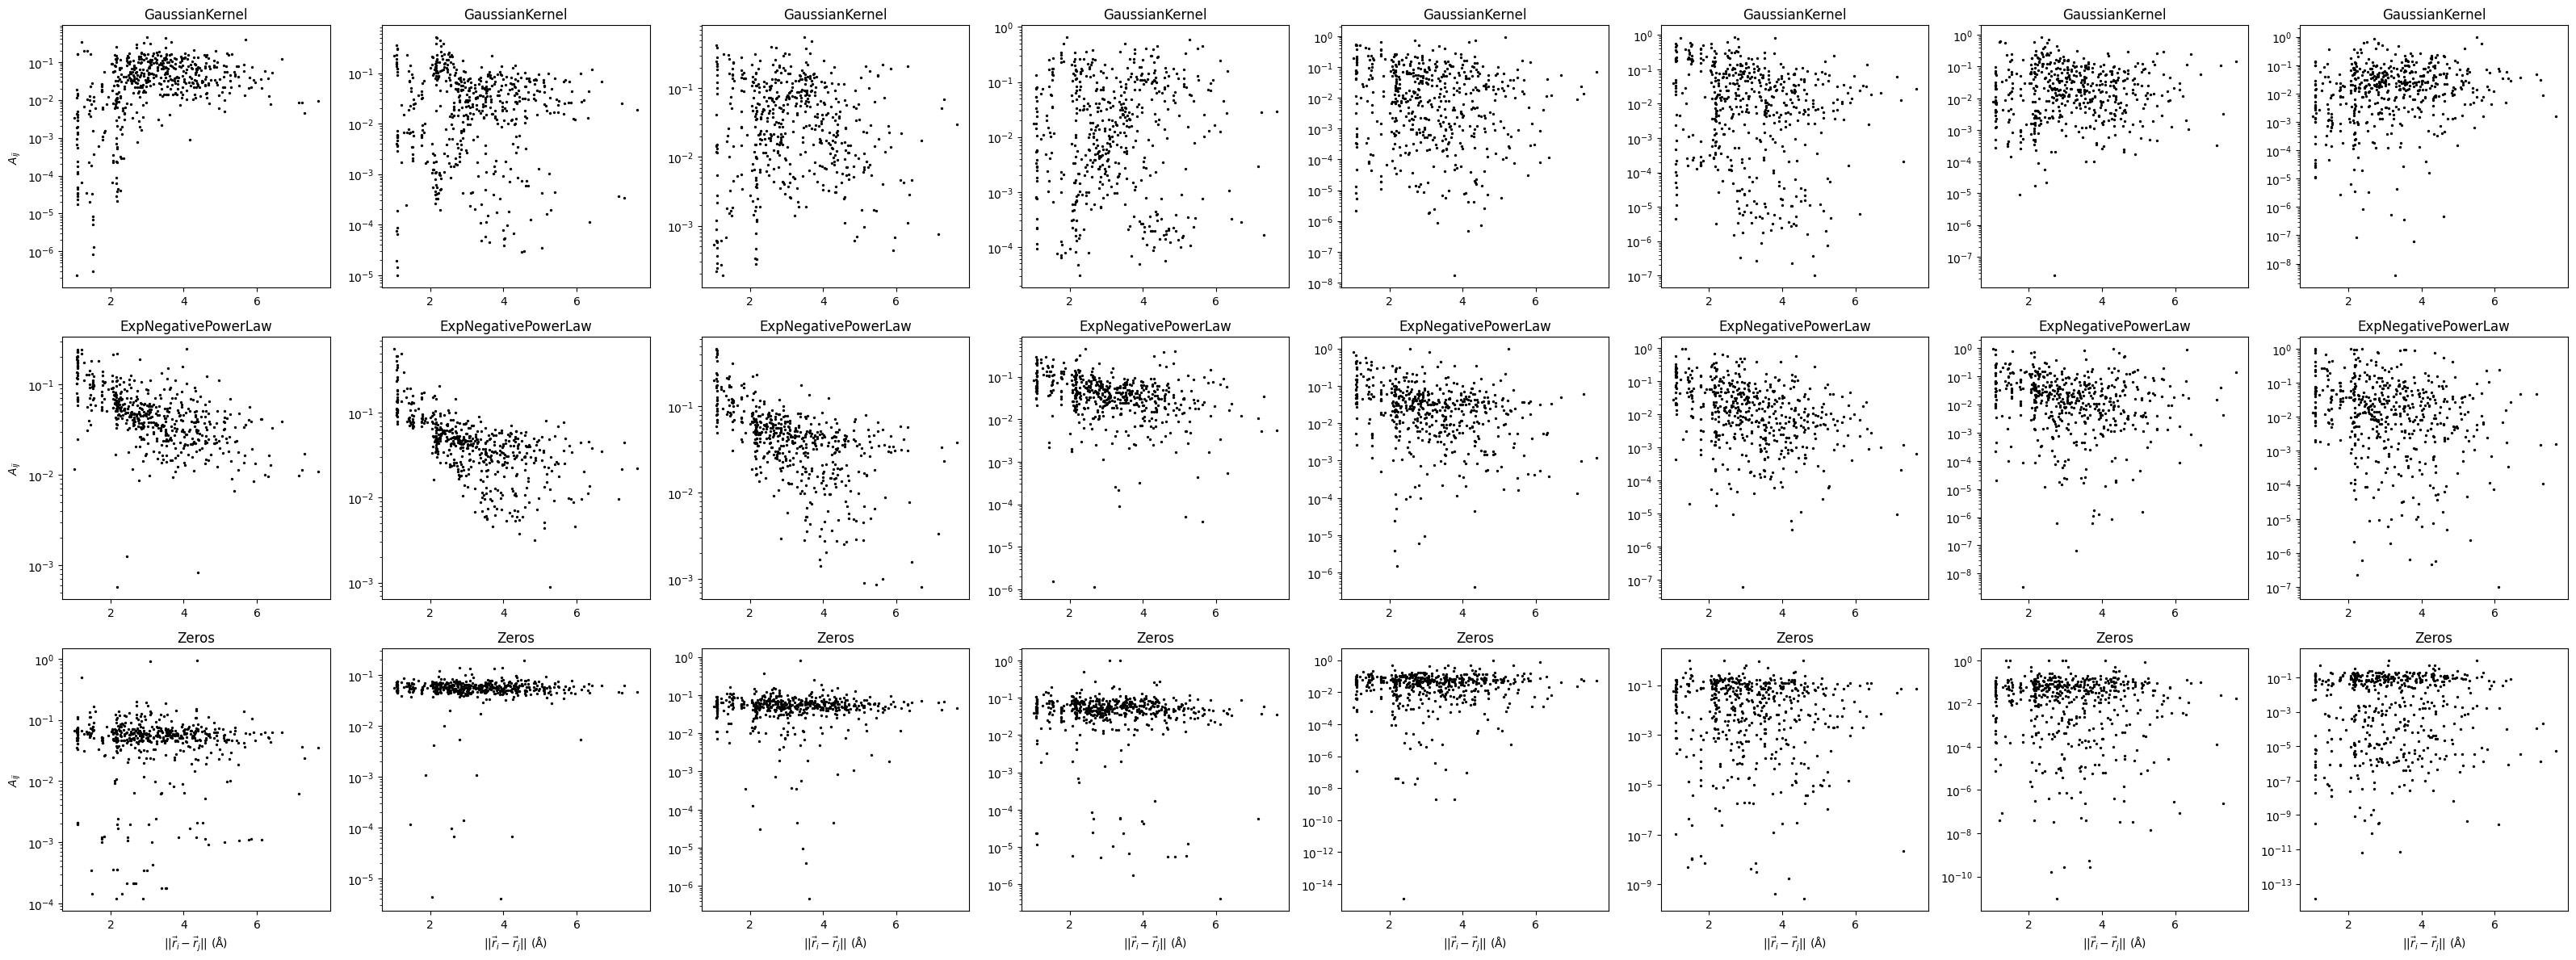

In [5]:
fig, axs = plt.subplots(
    len(models), 
    8,  
    figsize=(8 * 4, len(models) * 4)
)

for i, (model_key, model_activations) in enumerate(attns.items()):
    for j, block_activations in enumerate(model_activations):
        attn = block_activations

        sample_attn = attn[mask]

        axs[i, j].scatter(sample_d, sample_attn.detach().numpy(), s=2, color='k')
        axs[i, j].set_title(f'{model_key}')
        axs[i, j].set_yscale('log')

for ax in axs[:, 0]: ax.set_ylabel(r'$A_{ij}$')
for ax in axs[-1, :]: ax.set_xlabel(r'$|| \vec{r}_i - \vec{r}_j ||$ (Å)')

fig.tight_layout()